In [1]:
from fumarolePlumeModel import (derivs, wind, objectiveFn, objectiveFn2, 
                                objectiveFn3, loadICsParameters, loadExptData, 
                                pathname, integrator2 as integrator)
from scipy.io.matlab import loadmat
from scipy.integrate import ode, solve_ivp
from itertools import product
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import json

# Set numpy options, notably for the printing of floating point numbers
np.set_printoptions(precision=6)

# Set matplotlib options
mpl.rcParams['figure.dpi'] = 300

%reload_ext autoreload
%autoreload 2

In [2]:
run = 3

# Import table of experimental conditions
GCTA = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', 
                         sheet_name='CGSdata', skiprows=2, 
                         names=('exptNo', 'rhoa0', 'sig_rhoa0', 
                                'N', 'sig_N', 'rho0', 'sig_rho0', 
                                'U0', 'sig_U0', 'W', 'sig_W', 
                                'gp', 'sig_gp', 'Q0','sig_Q0', 
                                'M0', 'sig_M0', 'F0', 'sig_F0', 
                                'Ri_0', 'sig_Ri_o', 'W*','sig_W*'))

# Extract densities of ambient and plume, and calculate g' at the source
expt  = GCTA[GCTA['exptNo'] == run]
rhoa0 = expt['rhoa0']
rho0  = expt['rho0']
g = 981 #cm/s²
gp0   = (rhoa0 - rho0) / rhoa0 * g

parameters = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', 
                               sheet_name='CGSparameters')
b0theoretical = parameters[parameters['property'] == 'nozzleSize']['value'].values[0]
u0theoretical = expt['U0'].values[0]

### Create synthetic dataset for vertical plume and add noise

/home/david/Modelling/fumarolePlumeModel/fumarolePlumeModel.py:154: RuntimeWarning: invalid value encountered in sqrt
  b, u, gp = Q / np.sqrt(M), M / Q, F / Q


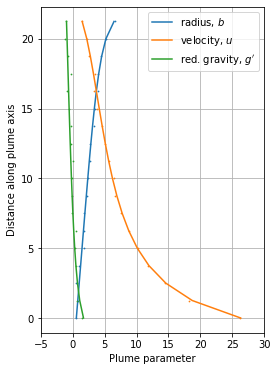

In [3]:
exptNo      = 3
plotResults = True

V0, p = loadICsParameters(pathname, exptNo, alpha=0.09, beta=0, m=1)

# Order of "p": alpha, beta, N, m, w
p = list(p)
p[1], p[4] = 0., 0.  # Set "wind" entrainment coefficient (beta), 
                     # and wind speed (w) to zero
p = tuple(p)

t1 = 30.
dt = .1
sexp = np.arange(0., t1 + dt, dt)
dsexp = np.diff(sexp)

Q0, M0, F0, theta0 = V0
s, V = integrator(V0, p)

sexp = np.copy(sexp)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(4, 6))
# ax[0].plot(V, s, '-')

Q, M, F, theta = [V[:,i] for i in range(4)]
b, u, gp = Q / np.sqrt(M), M / Q, F / Q

V2 = np.array([b, u, gp]).T
# ax[1].plot(V2, s, '-')
# ax[1].set_xlim((-5, 30))
# ax[1].grid()

sexp = np.copy(s)
dsexp = np.diff(sexp)

ax.plot(V2, s, '-')
ax.legend([r'radius, $b$', 'velocity, $u$', 'red. gravity, $g\'$'])
V3 = V2.copy()
for i in range(3):
    noise = np.random.normal(0, .2, len(sexp))
    V3[:,i] = V2[:,i] + noise
    ax.plot(V3[:,i], s, '.', c='C%d' % i, ms=1.5)
ax.set_xlim((-5, 30))
ax.set_xlabel('Plume parameter')
ax.set_ylabel('Distance along plume axis')
ax.grid()

bexp, uexp, gpexp = [V3[:,i] for i in range(3)]

gp0 = V0[2] / V0[0]

### Run jobs in parallel to search parameter space for maxima

In [4]:
from joblib import Parallel, delayed

import time
import warnings

njobs = 16
nGrid = 201                        # Number of grid points
b0Vec = np.linspace(.01, 2, nGrid) #cm
u0Vec = np.linspace(1, 30, nGrid)  #cm/s
Q0Vec = u0Vec * b0Vec**2           #cm3/s
M0Vec = Q0Vec * u0Vec              #cm4/s2
theta0 = np.pi / 2

sequence = [Q0Vec, M0Vec]

dexp = np.array([bexp, gpexp]).T

def parallel_job(Q0, M0):
    warnings.filterwarnings('ignore')
    
    F0 = gp0 * Q0
    v0 = [Q0, M0, F0, theta0]

    return objectiveFn3(v0, derivs, p, sexp, dexp, mode='lsq'), v0


t = time.time()
results = Parallel(n_jobs=njobs)(delayed(parallel_job)(Q0, M0) 
                                 for (Q0, M0) in list(product(*sequence)))
print("Job ran in %.3f s" % (time.time() - t))

## Deal out the results so as to 
objFn, initialConds = [], []

for result in results:
    objFn.append(result[0])
    initialConds.append(result[1])

initialConds = np.array(initialConds)
objFn = np.array(objFn).reshape((nGrid, nGrid))

Job ran in 31.232 s


### Minimization using Nelder-Mead (or other) algorithm

In [5]:
from scipy.optimize import minimize

def residual(pars, x, data=None, eps=None):
    return

# Start at random location within parameter space
v0 = initialConds[np.random.randint(0, len(initialConds))]
print("Initial vector: ", v0)
minimum = minimize(objectiveFn3, v0, 
                   args=(derivs, p, sexp, dexp), method='Nelder-Mead', 
                   bounds=((Q0Vec[0], Q0Vec[-1]), 
                           (M0Vec[0], M0Vec[-1]), 
                           (gp0*Q0Vec[0], gp0*Q0Vec[-1]), 
                           (np.pi/2, np.pi/2)))
print(minimum)
Qopt, Mopt, Fopt, thetaopt = minimum.x
bopt, uopt, gpopt = Qopt / np.sqrt(Mopt), Mopt / Qopt, Fopt / Qopt

Initial vector:  [  86.467869 1108.836454  144.419094    1.570796]
 final_simplex: (array([[  7.991505, 212.085833,  12.467962,   1.570796],
       [  7.991501, 212.085743,  12.467958,   1.570796],
       [  7.991507, 212.085855,  12.46796 ,   1.570796],
       [  7.991509, 212.085834,  12.467971,   1.570796],
       [  7.991506, 212.0858  ,  12.467961,   1.570796]]), array([-0.51013, -0.51013, -0.51013, -0.51013, -0.51013]))
           fun: -0.510129822553647
       message: 'Optimization terminated successfully.'
          nfev: 362
           nit: 208
        status: 0
       success: True
             x: array([  7.991505, 212.085833,  12.467962,   1.570796])



__________________________________________
                         b,      u,     g'
------------------------------------------
Theoretical values:  0.550, 26.307,  1.670
Optimised values:    0.549, 26.539,  1.560
Max of $\Theta(m,d)$:  0.398,  7.525,      -
__________________________________________


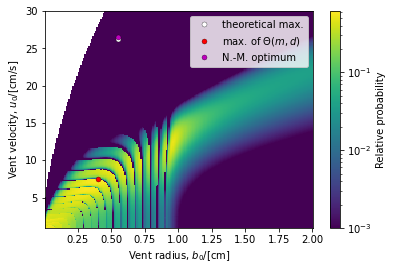

In [9]:
%matplotlib inline
from matplotlib.colors import LogNorm

objFn   = np.abs(objFn)
ui, bi  = np.where(objFn == np.nanmax(objFn))
# objFn[objFn == 0.] = np.nan
norm    = LogNorm(vmin=1e-3, vmax=np.nanmax(objFn))
MS = 10



print("\n", "_" * 42, sep='')
print("%42s" % "b,      u,     g\'")
print("-" * 42, sep='')
print("Theoretical values: %6.3f, %6.3f, %6.3f" % 
      (b0theoretical, u0theoretical, gp0))
print("Optimised values:   %6.3f, %6.3f, %6.3f" % 
      (bopt, uopt, gpopt))
print(r"Max of $\Theta(m,d)$: %6.3f, %6.3f, %6s" % 
      (b0Vec[bi], u0Vec[ui], '-'))
print("_" * 42, sep='')



fig, ax = plt.subplots(figsize=(6, 4))

pco = ax.pcolor(b0Vec, u0Vec, objFn, norm=norm)


p_, = ax.plot(b0theoretical, u0theoretical, '.w', label=r'theoretical max.', 
              markersize=MS, markeredgecolor='k', markeredgewidth=.3)

q_, = ax.plot(b0Vec[bi], u0Vec[ui], '.r', label=r'max. of $\Theta(m, d)$',
              markersize=MS, markeredgecolor='k', markeredgewidth=.3)

r_, = ax.plot(bopt, uopt, '.m', label=r'N.-M. optimum',
              markersize=MS, markeredgecolor='k', markeredgewidth=.3)

ax.set_xlabel(r'Vent radius, $b_0$/[cm]')
ax.set_ylabel(r'Vent velocity, $u_0$/[cm/s]')
leg = plt.legend()
cba = plt.colorbar(pco)
cba.set_label('Relative probability')

fig.savefig('images/ProbDensityFn_CA_run%d.png' % exptNo, dpi=300)

| | $b$ | $u$ | $g'$ |
|-|-----|-----|------|
| Theoretical values: |  0.550 | 26.307 | 1.670 |
|Optimised values: | 0.549 | 26.539 | 1.560 |
|Max of $\Theta(m,d)$: | 0.398 | 7.525 | - |

### Comparison of final plot with synthetic data

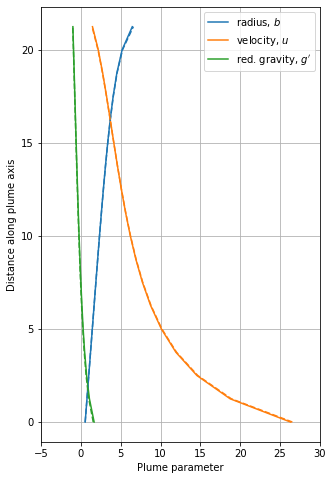

In [10]:
s, V = integrator(minimum.x, p)

Q, M, F, theta = V.T
b, u, gp = Q / np.sqrt(M), M / Q, F / Q
Vfinal = np.array([b, u, gp])

fig, ax = plt.subplots(figsize=(5, 8))

ax.plot(V2, s, '-')
ax.legend([r'radius, $b$', 'velocity, $u$', 'red. gravity, $g\'$'])
for i in range(3):
    ax.plot(Vfinal[i], s, '--', c='C%d' % i)

ax.set_xlim((-5, 30))
ax.set_xlabel('Plume parameter')
ax.set_ylabel('Distance along plume axis')
ax.grid()

In [ ]:
# from lmfit import minimize, Parameters, Model

# params  = Parameters()
# # minimum = minimize(objectiveFn3, params, args=(derivs, p, sexp, dexp))